This notebook contains the experiments conducted to develop the annual prediction models. It begins by validating the preprocessing steps originally designed for seasonal models. Next, it performs feature selection to evaluate the impact of including various modes of variability indices on model performance.

Dependencies and input files:
- preprocessing_functions.py: Contains shared preprocessing routines.
- experiment_functions.py: Includes functions to load and analyze experiment results.
- model_functions.py: Defines and optimizes model configurations.

In [ ]:
from warnings import warn
from preprocessing_functions import *
from models_functions import *
from experiments_functions import *

# 1) Validate preprocessing

In [ ]:
# load the indicators, make a custom annual preprocessing and transform to
# dataframe
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr", "txx"])

annual_dict = annual_preprocessing(indicators_dict)

df = dict_to_dataframe(annual_dict)

calculating montly mean for pr


/home/vgarcia/miniconda3/envs/myenv/lib/python3.11/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [ ]:
# calculate 95% confidence intervals for median and variance
for indicator in ["pr_anom", "rx90p_anom"]:
    print(indicator)
    data = df[indicator].dropna()

    # Bootstrap parameters
    n_iterations = 10000
    n_size = len(data)

    # Store the variances from bootstrap samples
    variances = []

    np.random.seed(42)  # for reproducibility

    for _ in range(n_iterations):
        sample = np.random.choice(data, size=n_size, replace=True)
        var = np.var(sample, ddof=1)  # sample variance
        variances.append(var)

    # Compute the 95% CI of the median of these variances
    median_variance = np.median(variances)
    lower, upper = np.percentile(variances, [2.5, 97.5])

    print(f"Median Variance: {median_variance:.4f}")
    print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

Indicator


# 2) Feature Adding new indexes

## Store new indexes in txt

In [ ]:
# functions to make new indexes files
index_name = "Nino3.4-HadISST"
folder_path = f"/data/dl20-data/climate_operational/Victor_data/climate_index/Nino3.4"

text_content = """\

"""

# create the directory and store the index

"""
os.makedirs(folder_path)
print(folder_path)
filename = f"{folder_path}/NASA-{index_name}.txt"
with open(filename, "w") as file:
    file.write(text_content)
"""

/data/dl20-data/climate_operational/Victor_data/climate_index/Nino3.4


## Baseline cases

In [ ]:
experiment_name = f"NoAggr"
dataset = "era5"
out_path = f"/home/vgarcia/notebooks/{dataset}.csv"

# common preprocessing
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr", "txx"])
annual_dict = annual_preprocessing(indicators_dict)

df = dict_to_dataframe(annual_dict)
df = df.drop("txx_anom", axis = 1)

df_merged = df_annual_add_index_variables(df, annual_trend = True)
df_scaled = encode_and_scale(df_merged)

cols = ['rx90p_anom', 'pr_anom'] + [col for col in df_scaled.columns if col not in ['rx90p_anom', 'pr_anom']]
df_scaled = df_scaled[cols]

/home/vgarcia/miniconda3/envs/myenv/lib/python3.11/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [ ]:
# train and evaluate models
X_train, y_train, X_val, y_val = train_test_split(df_scaled, include_years=False)

models = build_and_train_models(X_train, y_train, models = {"Lasso": MultiTaskLassoCV(cv = 20, random_state = 123),
                                                            "HGBR" : MultiOutputRegressor(HistGradientBoostingRegressor(random_state=123))}, experiment_name = experiment_name, target_lag_prefix = "_SON", time_aggr="year")

evaluate_models(X_val, y_val, models, store_testing=True, out_path = "/home/vgarcia/experiments/annual_ML/", experiment_name=experiment_name)

Plot saved to /home/vgarcia/experiments/annual_ML/NoAggr_Pearson_corr


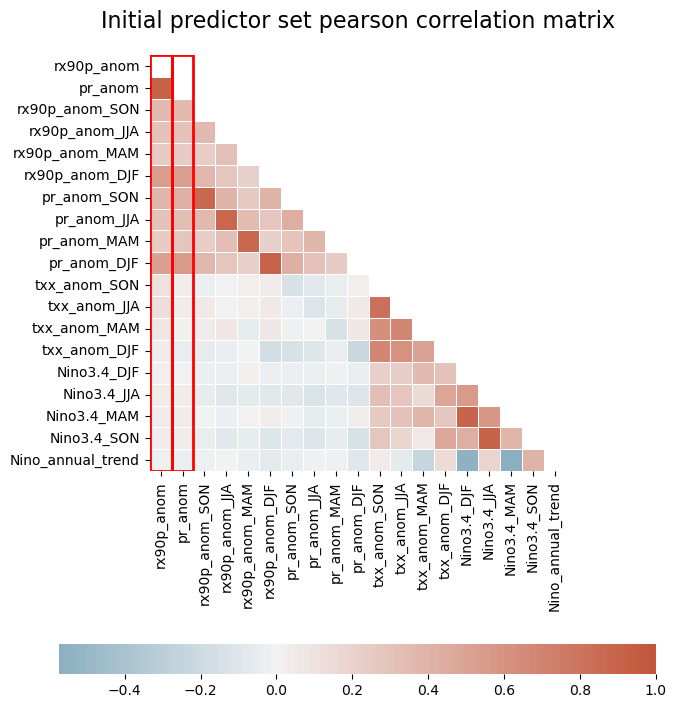

Plot saved to /home/vgarcia/experiments/annual_ML/NoAggr_Spearman_corr


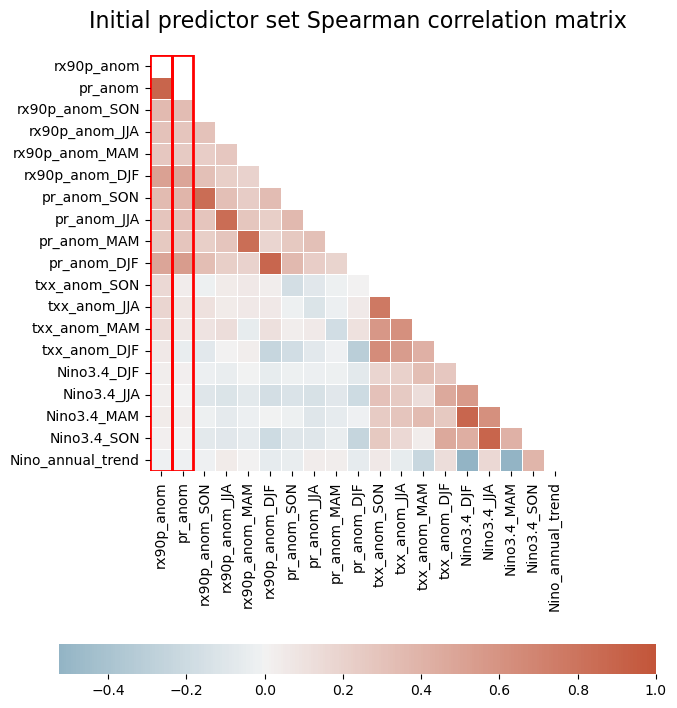

In [ ]:
# analyse correlation analysis
corr_plot(df_scaled.drop("year", axis = 1), f"Initial predictor set pearson correlation matrix", outpath=f"/home/vgarcia/experiments/annual_ML/{experiment_name}_Pearson_corr", target_vars=["rx90p_anom", "pr_anom"])
corr_plot(df_scaled.drop("year", axis = 1), f"Initial predictor set Spearman correlation matrix", outpath=f"/home/vgarcia/experiments/annual_ML/{experiment_name}_Spearman_corr", target_vars=["rx90p_anom", "pr_anom"], correlation="spearman")

## Adding different indices

In [95]:
experiment_name = "Indexes"
indexes = ["IOD", "NAO", "Nino3.4", "PDO", "SOI"]

indicators_dict = calculate_indicators(indicators = ["rx90p", "pr", "txx"])

#aggregated_indicators = aggregate_by_pixel(indicators_dict, 10, 75)
annual_dict = annual_preprocessing(indicators_dict)

df = dict_to_dataframe(annual_dict)
df = df.drop("txx_anom", axis = 1)

for index_name in indexes:
    print("Adding", index_name)
    index_path = f"/data/dl20-data/climate_operational/Victor_data/climate_index/{index_name}/NASA-{index_name}.txt"
    df = df_annual_add_index_variables(df, annual_trend = True, index_name= index_name, index_path= index_path)

df_scaled = encode_and_scale(df)

cols = ['rx90p_anom', 'pr_anom'] + [col for col in df_scaled.columns if col not in ['rx90p_anom', 'pr_anom']]
df_scaled = df_scaled[cols]

df_scaled.to_csv("test_zone.csv", index = False)

calculating montly mean for pr
Adding IOD
Adding NAO
Adding Nino3.4
Adding PDO
Adding SOI


In [113]:
# remove seasons of the indexes and retain only annual mean
seasons = ["DJF", "MAM", "JJA", "SON"]
index_seasonal_features = [f"{var}_{season}" for var in indexes for season in seasons]

df_scaled = df_scaled.drop(index_seasonal_features, axis = 1)

## Feature selection loop

In [5]:
df_scaled = pd.read_csv("/home/vgarcia/notebooks/test_zone.csv")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# Step 1: Define base feature list
variables = ["rx90p", "pr", "txx"]
seasons = ["DJF", "MAM", "JJA", "SON"]
base_features = [f"{var}_anom_{season}" for var in variables for season in seasons] + ["lat", "lon"]

#base_features = base_features + ["Nino3.4_DJF", "Nino3.4_MAM", "Nino3.4_JJA", "Nino3.4_SON"]

# Step 2: Train-validation split
X_train, y_train, X_val, y_val = train_test_split(df_scaled, include_years=False)

# Step 4: Forward selection with custom score and base features
def custom_score(y_true, y_pred):
    r2_raw = r2_score(y_true, y_pred, multioutput="raw_values")
    mae_raw = mean_absolute_error(y_true, y_pred, multioutput="raw_values")
    combined = 0.7 * np.mean(r2_raw) - 0.3 * np.mean(mae_raw)

    return combined, r2_raw, mae_raw

# Step 4: Forward selection with logging to DataFrame
def forward_selection_custom(X_train, y_train, X_val, y_val, base_features, max_features=None, model=LinearRegression()):
    remaining_features = [f for f in X_train.columns if f not in base_features]
    selected_features = base_features.copy()

    # Initialize base model
    best_model = model.fit(X_train[selected_features], y_train)
    y_pred = best_model.predict(X_val[selected_features])
    best_score, r2_val, mae_val = custom_score(y_val, y_pred)

    # Log results in DataFrame
    results = pd.DataFrame(columns=["added_feature", "score", "r2", "mae"])
    step = 0
    results.loc[step] = ["BASE", best_score, r2_val, mae_val]

    while remaining_features and (max_features is None or len(selected_features) < max_features):
        best_candidate = None
        best_candidate_score = -np.inf
        best_r2 = None
        best_mae = None

        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            model = model.fit(X_train[candidate_features], y_train)
            y_pred = model.predict(X_val[candidate_features])
            score, r2, mae = custom_score(y_val, y_pred)

            if score > best_candidate_score:
                best_candidate_score = score
                best_candidate = feature
                best_r2 = r2
                best_mae = mae

        if best_candidate_score > best_score:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_score = best_candidate_score
            step += 1
            results.loc[step] = [best_candidate, best_score, best_r2, best_mae]
        else:
            break

    return selected_features, results

# Step 5: Run forward selection
selected, score_progression = forward_selection_custom(
    X_train, y_train, X_val, y_val,
    base_features=base_features,
    max_features = None,  # or set a limit
    model=MultiOutputRegressor(HistGradientBoostingRegressor(random_state=123))
)

print("Selected features:", selected)
print("Score progression:", score_progression)


In [156]:
score_progression.to_csv("FeatureSelection_validation.csv")

In [8]:
experiment_name = "BestSet"
models = build_and_train_models(X_train[selected], y_train, models = {"HGBR" : MultiOutputRegressor(HistGradientBoostingRegressor(random_state=123)), 
                                                                      "Lasso": MultiTaskLassoCV(cv = 20, random_state = 123)}, experiment_name = experiment_name, target_lag_prefix = "_SON", time_aggr="year")

evaluate_models(X_val[selected], y_val, models, store_testing=True, out_path = "/home/vgarcia/experiments/annual_ML/", experiment_name=experiment_name)

---Training (MSE, MSSS, MAE, R2)---
HGBR: [0.09354928 0.06462733], [0.74287275 0.78650626], [0.18518495 0.15764367], [0.73379335 0.78237812]
Lasso: [0.22732058 0.18066289], [0.37519222 0.40318753], [0.26364804 0.25707155], [0.35312967 0.3916475 ]
All models trained
---Testing (MSE, MSSS, MAE, R2)---
Climatology: [0.31887625 0.2195932 ], [0. 0.], [0.355645   0.30602168], [-0.06122285  0.05095079]
BestSet_HGBR: [0.20537568 0.14840068], [0.35593923 0.32420187], [0.28700366 0.25527165], [0.31650799 0.35863431]
BestSet_Lasso: [0.19833125 0.14489068], [0.37803067 0.34018597], [0.28191372 0.25546481], [0.33995193 0.37380401]


# Check results of experiments

In [ ]:
df_sorted = load_experiment_results("/home/vgarcia/experiments/annual_ML")